In [1]:
# import the libraries that we need

import perceval as pcvl
import perceval.components as comp
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from math import comb
from itertools import chain

In [2]:
# Define our target Fourier series

def g1(x):
    return 0.1 + (0.15 + 0.15j)*np.exp(1j*x) + (0.15 - 0.15j)*np.exp(-1j*x)

def G1(res,x):
    return (res - g1(x)).real

In [3]:
# define the number of modes + photons
n = 3
m = 3

In [4]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = -6  # minimum of the interval on which we wish to approximate our function
range_max = 6 # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max, n_grid) 

# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / n_grid

fock_dim = sum(comb(m+i-2,i) for i in range(n+1))
a = 200

In [5]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
input_state = pcvl.BasicState([1]*n+[0]*(m-n))

In [6]:
def non_feed_forward_fourier_approximator(params):
    '''function to approximate our fourier series using an parameterized quantum circuit'''

    coefs = lambda_random
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    px = pcvl.P("x")
    U_2 = pcvl.Matrix.random_unitary(m-1, params[2*m**2:2*m**2 + 2*(m-1)**2])
    c = pcvl.Unitary(U_1) // (1, pcvl.PS(px)) // (1,pcvl.Unitary(U_2))
    Y = np.zeros(len(X))
    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    for i in range(len(X)):
        x = X_norm[i]
        px.set_value(np.pi * x / 3)
        s1 = simulator_backend(c.compute_unitary())
        #s1.U = c.compute_unitary(use_symbolic=False)
        Y[i] = np.sum(np.multiply(s1.all_prob(input_state), coefs))
    later = time.time()
    return Y

In [7]:
def non_feed_forward_computation_loss(parameters):
    "compute the loss function of a given differential equation in order for it to be optimized"
    global current_loss
    global computation_count
    computation_count += 1
    res = non_feed_forward_fourier_approximator(parameters)

    loss = 0

    loss +=np.sum((G1(res,X))**2)
    current_loss = loss / len(X)
    return current_loss

In [8]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    now = time.time()
    pbar.set_description("M = %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    start_time = now

In [9]:
pbar = tqdm()
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []
nff_init_params = np.random.normal(size=(2*m**2 + 2*(m-1)**2))
lambda_random =  2 * a * np.random.rand(fock_dim) - a
res_nff = minimize(non_feed_forward_computation_loss, nff_init_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})
loss_evolution_nff = (list(map(list, zip(*loss_evolution))))[0]

M = 3 Loss: 0.04725 #computations: 2160 elapsed: 1.30499: : 59it [01:57,  1.51s/it]

In [10]:
prob_table=[np.zeros((comb(p+m-2, p,))) for p in range(n + 1)] # probability table
beg_idx = [sum([comb(p + m - 2, p) for p in range(q)]) for q in range(n + 2)]

In [11]:
def prob_adapt():
    '''this returns the probabilities of all the adaptive measurements'''
    s1 = simulator_backend(first_generic.compute_unitary())
    probs = np.array(s1.all_prob(input_state))
    return [sum([complex(probs[q]).real for q in range(beg_idx[p], beg_idx[p + 1])]) for p in range(n + 1)]

In [12]:
def feed_forward_table(x, coeff):
    
    px.set_value(x*np.pi/3)
    for p in range(n + 1):
        # compute the unitary for each adaptive circuit
        s1 = simulator_backend(full_circuit[p].compute_unitary())
        # get the probabilities for each output state, for the given adaptive msmt. 
        prob_table[p] = np.array(s1.all_prob(input_state))[beg_idx[p]: beg_idx[p + 1]]
        # multiply by the adaptive msmt probability to give the probability distribution for each output state.
        # Then normalize.
        prob_table[p] *= coeff[p] / np.sum(prob_table[p]) # probability normalization        

In [13]:
def feed_forward_model(x,parameters, coeff):
    '''This function gives us the fourier estimate using the quantum parameterized circuit for given data point'''
    feed_forward_table(x, coeff) # computation of the probability table for the (n+1) circuits
    fvalue = 0
    # multiply all our output probabilities by our fourier coefficients to give fourier approximation for given data point x.
    fvalue += np.dot(list(chain.from_iterable(prob_table)),lambda_random)
    return fvalue

In [14]:
def feed_forward_fourier_approximator(parameters):
    '''This function provides set of results for the fourier estimate given a set of circuit parameters for the dataset'''
    global full_circuit
    global first_generic
    global px
    # define our first circuit which is used for the adaptive msmt probabilities. 
    first_generic = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2*m**2]), name="W1")
    
    U_P = []
    full_circuit=[]
    px = pcvl.P("x")
    for p in range(n+1):

        U_P.append(pcvl.Unitary(pcvl.Matrix.random_unitary(m-1, parameters[2*m**2 + p*2*(m-1)**2:2*m**2 + ((p+1)*2*(m-1)**2)]), name=f"W3_{p}"))
        temp = pcvl.Circuit(m).add(0, first_generic)\
                              .add(1, comp.PS(px))\
                              .add(1, U_P[p])
        full_circuit.append(temp)
    # define our adaptive probabilities
    coeff = prob_adapt()

    res = np.zeros(len(X))
    # loop over our dataset
    for i in range(len(X)):        
        res[i] = feed_forward_model(X[i],parameters,coeff)
    return res

In [15]:
def feed_forward_computation_loss(parameters):
    '''This is our loss function. It sums the difference between our approximation and expected result. 
        This is the function we want to minimise'''
    global current_loss
    global computation_count
    computation_count += 1
    res = feed_forward_fourier_approximator(parameters)
    loss = 0 
    loss +=np.sum((G1(res,X))**2)

    current_loss = loss / len(X)
    return loss

In [16]:

computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm()

ff_init_params = np.append(nff_init_params[:2*m**2],np.tile(nff_init_params[2*m**2:],n+1))
res_ff = minimize(feed_forward_computation_loss, ff_init_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})
loss_evolution_ff = (list(map(list, zip(*loss_evolution))))[0]
now = time.time()



M = 3 Loss: 0.04725 #computations: 2160 elapsed: 1.30499: : 59it [01:57,  1.99s/it]

M = 3 Loss: 1831.27821 #computations: 153 elapsed: 37.59173: : 0it [00:37, ?it/s]
M = 3 Loss: 1831.27821 #computations: 153 elapsed: 37.59173: : 1it [00:37, 37.59s/it]
M = 3 Loss: 1073.04177 #computations: 255 elapsed: 24.04376: : 1it [01:01, 37.59s/it]
M = 3 Loss: 1073.04177 #computations: 255 elapsed: 24.04376: : 2it [01:01, 29.62s/it]
M = 3 Loss: 265.30737 #computations: 306 elapsed: 11.82380: : 2it [01:13, 29.62s/it] 
M = 3 Loss: 265.30737 #computations: 306 elapsed: 11.82380: : 3it [01:13, 21.49s/it]
M = 3 Loss: 95.52479 #computations: 408 elapsed: 22.40132: : 3it [01:35, 21.49s/it] 
M = 3 Loss: 95.52479 #computations: 408 elapsed: 22.40132: : 4it [01:35, 21.85s/it]
M = 3 Loss: 36.41520 #computations: 459 elapsed: 12.54168: : 4it [01:48, 21.85s/it]
M = 3 Loss: 36.41520 #computations: 459 elapsed: 12.54168: : 5it [01:48, 18.50s/it]
M = 3 Loss: 21.80691 #computations: 561 elapsed: 23.12291: : 5it [

M = 3 Loss: 0.00202 #computations: 3315 elapsed: 10.56542: : 46it [12:30, 14.56s/it]
M = 3 Loss: 0.00202 #computations: 3315 elapsed: 10.56542: : 47it [12:30, 13.36s/it]
M = 3 Loss: 0.00202 #computations: 3366 elapsed: 11.56672: : 47it [12:42, 13.36s/it]
M = 3 Loss: 0.00202 #computations: 3366 elapsed: 11.56672: : 48it [12:42, 12.82s/it]
M = 3 Loss: 0.00202 #computations: 3417 elapsed: 10.81619: : 48it [12:52, 12.82s/it]
M = 3 Loss: 0.00202 #computations: 3417 elapsed: 10.81619: : 49it [12:52, 12.22s/it]
M = 3 Loss: 0.00202 #computations: 3519 elapsed: 20.10128: : 49it [13:13, 12.22s/it]
M = 3 Loss: 0.00202 #computations: 3519 elapsed: 20.10128: : 50it [13:13, 14.58s/it]
M = 3 Loss: 0.00202 #computations: 3570 elapsed: 9.03163: : 50it [13:22, 14.58s/it] 
M = 3 Loss: 0.00202 #computations: 3570 elapsed: 9.03163: : 51it [13:22, 12.92s/it]
M = 3 Loss: 0.00202 #computations: 3621 elapsed: 12.29790: : 51it [13:34, 12.92s/it]
M = 3 Loss: 0.00202 #computations: 3621 elapsed: 12.29790: : 52it 

C:\Users\StephenCollins\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


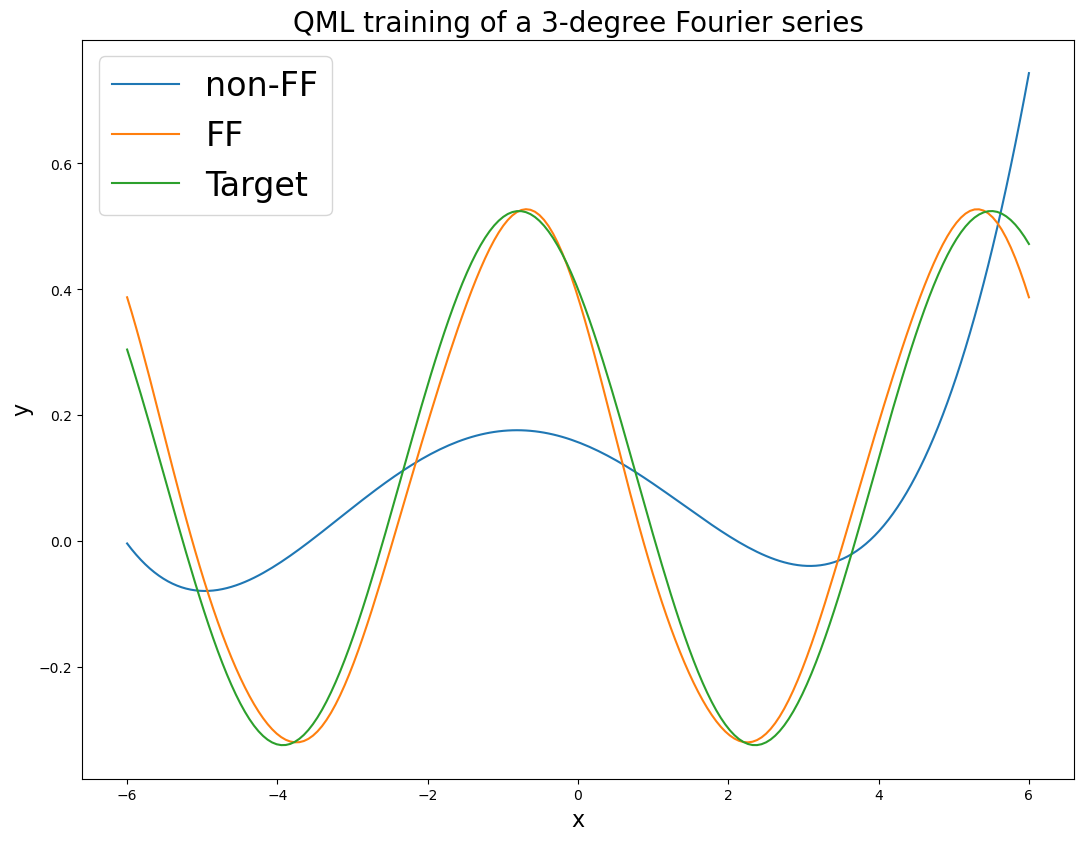

In [17]:
# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

X = np.linspace(-6, 6, 200)
plt.plot(X,non_feed_forward_fourier_approximator(res_nff.x),label='non-FF')
plt.plot(X,feed_forward_fourier_approximator(res_ff.x),label='FF')
plt.plot(X, g1(X), label = 'Target')
plt.xlabel("x", fontsize = 16)
plt.ylabel("y", fontsize = 16)
plt.title('QML training of a 3-degree Fourier series',fontsize = 20)
plt.legend(fontsize = 24)
plt.show()

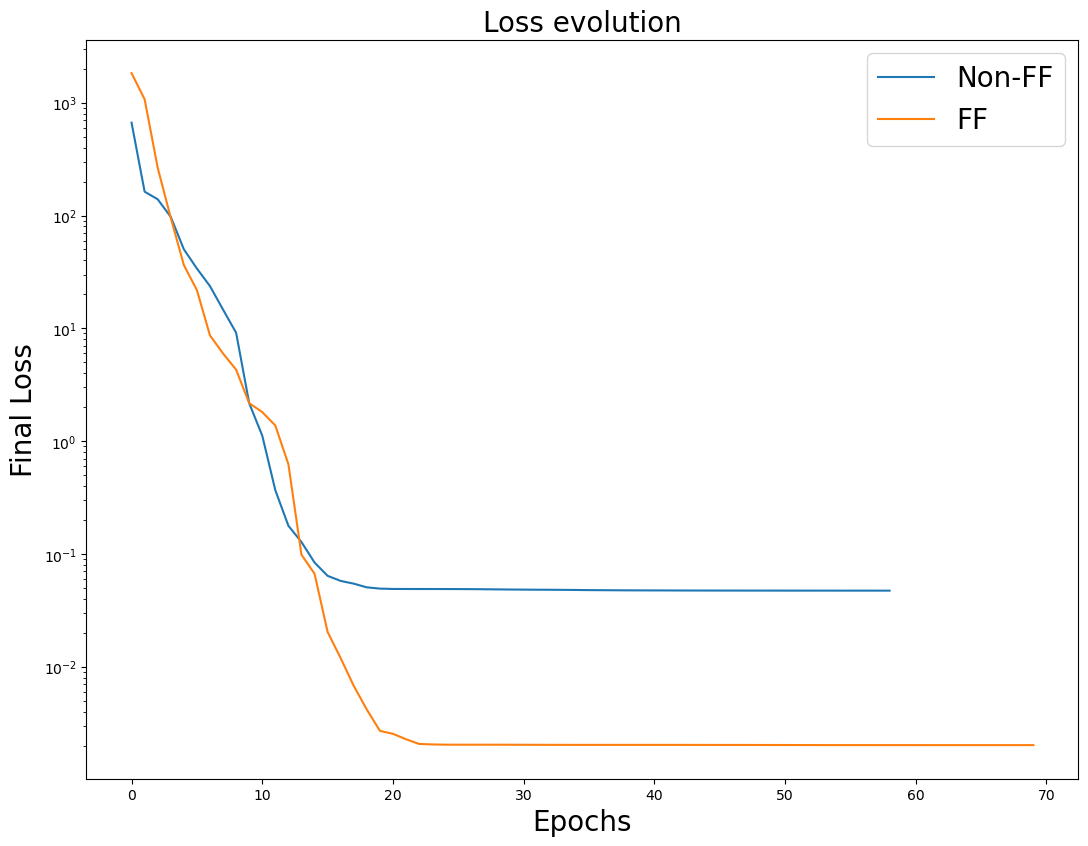

In [18]:
plt.plot(loss_evolution_nff,label = 'Non-FF')
plt.plot(loss_evolution_ff,label = 'FF')

plt.yscale("log")
plt.xlabel("Epochs",fontsize = 20)
plt.ylabel("Final Loss",fontsize = 20)
plt.title('Loss evolution',fontsize = 20)
plt.legend(fontsize = 20)
plt.show()